In [3]:
import torch
from torchinfo import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import cv2, os
from matplotlib import pyplot as plt
import albumentations as A
import numpy as np

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
from typing import Tuple
from going_modular.model.MagFaceRecognition import MagFaceConcatRecognition

# Data augmentation

In [38]:
albedo_path = './Dataset/Albedo/train/1001/2008-03-02_11-25-38.exr'
depthmap_path = './Dataset/Depth_Map/train/1001/2008-03-02_11-25-38.exr'
normalmap_path = './Dataset/Normal_Map/train/1001/2008-03-02_11-25-38.exr'

albedo = cv2.cvtColor(cv2.imread(albedo_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_GRAY2BGR)
depthmap = cv2.cvtColor(cv2.imread(depthmap_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_GRAY2BGR)
normalmap = cv2.cvtColor(cv2.imread(normalmap_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

## Gause noise

In [10]:
class GaussianNoise(object):
    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        row, col, ch = img.shape

        # Tính toán kích thước của vùng ảnh sẽ nhận nhiễu
        min_size = int(row * col * 0.1)
        max_size = int(row * col * 0.25)
        area_size = np.random.randint(min_size, max_size)

        # Tạo ma trận mask để chỉ định vùng của ảnh sẽ nhận nhiễu
        mask = np.zeros((row, col))
        x = np.random.randint(0, col)
        y = np.random.randint(0, row)
        x_end = min(x + int(np.sqrt(area_size)), col)
        y_end = min(y + int(np.sqrt(area_size)), row)
        mask[y:y_end, x:x_end] = 1

        # Tạo ma trận nhiễu Gaussian có std ngẫu nhiên
        std = np.random.uniform(0, 0.1)
        gauss = np.random.normal(self.mean, std, (row, col, ch))

        # Áp dụng nhiễu vào phần của ảnh được chỉ định bởi mask
        noisy_img = img + gauss * mask[:, :, np.newaxis]
        noisy_img = np.clip(noisy_img, 0, 1)

        return noisy_img
    
make_noise = GaussianNoise()

[160, 188, 256, 256]
[253, 244, 256, 256]
[125, 123, 235, 233]


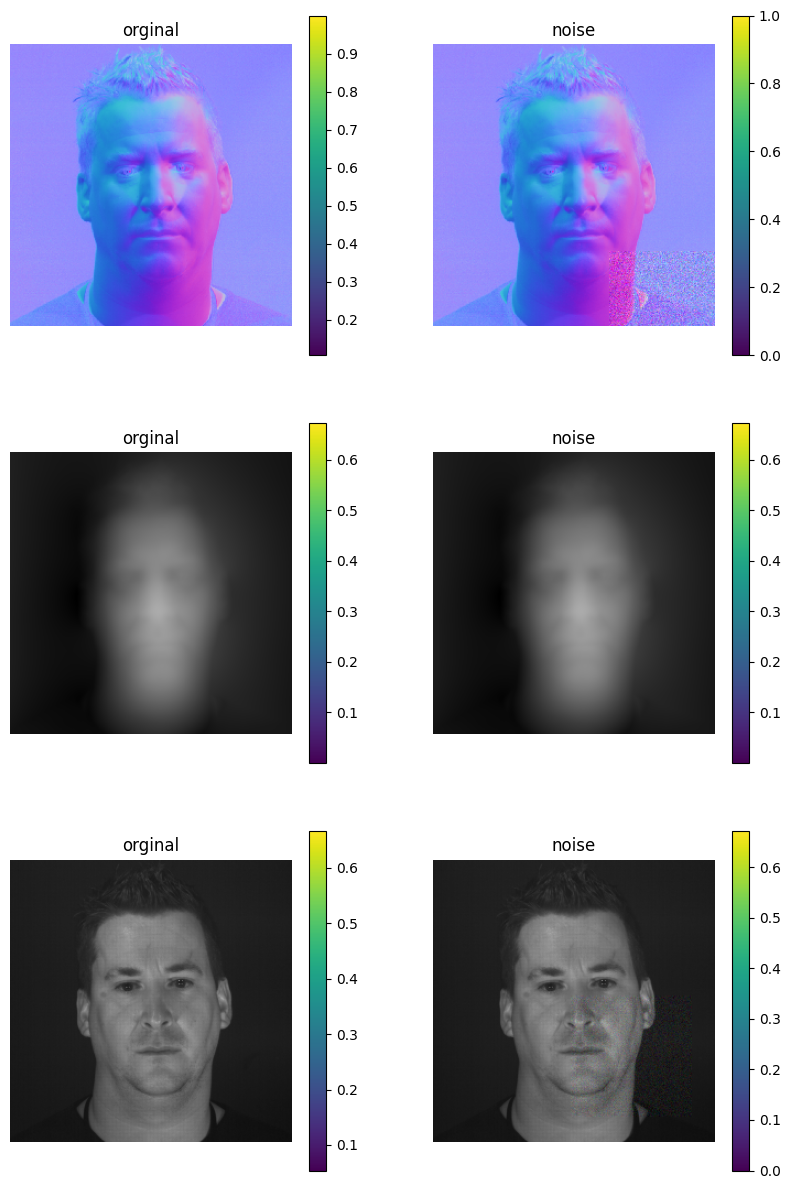

In [12]:
plt.figure(figsize=(10,15))

plt.subplot(3,2,1)
plt.title('orginal')
plt.imshow(normalmap)
plt.axis('off')
plt.colorbar()

normalmap_reseize, box = make_noise(normalmap)
print(box)
plt.subplot(3,2,2)
plt.title('noise')
plt.imshow(normalmap_reseize)
plt.axis('off')
plt.colorbar()

depthmap_resize, box = make_noise(depthmap)
print(box)
plt.subplot(3,2,3)
plt.title('orginal')
plt.imshow(depthmap)
plt.axis('off')
plt.colorbar()

plt.subplot(3,2,4)
plt.title('noise')
plt.imshow(depthmap_resize)
plt.axis('off')
plt.colorbar()

albedo_resize, box = make_noise(albedo)
print(box)
plt.subplot(3,2,5)
plt.title('orginal')
plt.imshow(albedo)
plt.axis('off')
plt.colorbar()

plt.subplot(3,2,6)
plt.title('noise')
plt.imshow(albedo_resize)
plt.axis('off')
plt.colorbar()

plt.show()

## RandomResizeCropRect

In [32]:
class RandomResizedCropRect(object):
    def __init__(self, size, scale=(0.8, 1.0)):
        self.size = size
        self.scale = scale

    def __call__(self, img):
        # Lấy kích thước ảnh
        img_width, img_height, _ = img.shape

        # Tính toán kích thước và tọa độ cho crop
        width = int(img_width * np.random.uniform(*self.scale))
        height = int(img_height * np.random.uniform(*self.scale))
        x = np.random.randint(0, img_width - width + 1)
        y = np.random.randint(0, img_height - height + 1)

        # Crop ảnh
        img = img[y:y+height, x:x+width]

        # Resize ảnh về kích thước mong muốn
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)

        return img
    
random_resize = RandomResizedCropRect(size=256)

[125, 123, 235, 233]
[125, 123, 235, 233]
[125, 123, 235, 233]


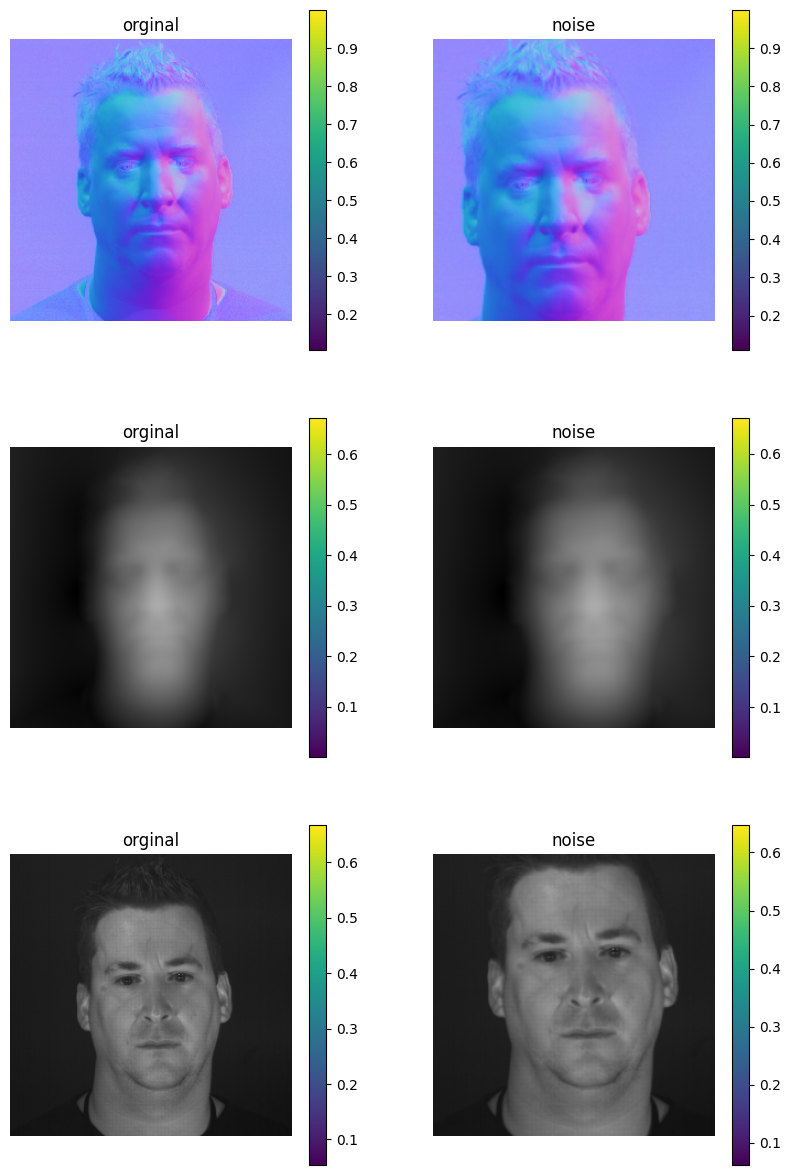

In [34]:
plt.figure(figsize=(10,15))

plt.subplot(3,2,1)
plt.title('orginal')
plt.imshow(normalmap)
plt.axis('off')
plt.colorbar()

normalmap_reseize= random_resize(normalmap)
print(box)
plt.subplot(3,2,2)
plt.title('noise')
plt.imshow(normalmap_reseize)
plt.axis('off')
plt.colorbar()

depthmap_resize= random_resize(depthmap)
print(box)
plt.subplot(3,2,3)
plt.title('orginal')
plt.imshow(depthmap)
plt.axis('off')
plt.colorbar()

plt.subplot(3,2,4)
plt.title('noise')
plt.imshow(depthmap_resize)
plt.axis('off')
plt.colorbar()

albedo_resize= random_resize(albedo)
print(box)
plt.subplot(3,2,5)
plt.title('orginal')
plt.imshow(albedo)
plt.axis('off')
plt.colorbar()

plt.subplot(3,2,6)
plt.title('noise')
plt.imshow(albedo_resize)
plt.axis('off')
plt.colorbar()

plt.show()

## Tích hợp vào albumentation

In [73]:
import numpy as np
import cv2
import albumentations as A

class RandomResizedCropRect(A.ImageOnlyTransform):
    def __init__(self, size, scale=(0.8, 1.0), p = 1.0):
        super().__init__(p)  # Khởi tạo base class với p là xác suất
        self.size = size
        self.scale = scale
    
    def apply(self, img, random_scale, x, y):
        # Lấy kích thước ảnh
        img_height, img_width, _ = img.shape

        # Tính toán kích thước và tọa độ cho crop
        width = int(img_width * random_scale)
        height = int(img_height * random_scale)

        # Crop ảnh
        img = img[y:y+height, x:x+width]

        # Resize ảnh về kích thước mong muốn
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)

        return img
    
    def __call__(self, **kwargs):
        # Tạo giá trị ngẫu nhiên chung cho tất cả các ảnh
        random_scale = np.random.uniform(*self.scale)
        img_height, img_width, _ = kwargs['image'].shape  # Lấy kích thước của ảnh chính
        x = np.random.randint(0, img_width - int(img_width * random_scale) + 1)
        y = np.random.randint(0, img_height - int(img_height * random_scale) + 1)
        
        # Tiến hành transform trên tất cả các ảnh (chính và bổ sung)
        result = {}

        # Lặp qua tất cả các target (ảnh chính và các ảnh bổ sung)
        for key, image in kwargs.items():
            # Áp dụng biến đổi cho mỗi ảnh với cùng một giá trị random_scale và tọa độ x, y
            result[key] = self.apply(image, random_scale=random_scale, x=x, y=y)
        
        return result

In [74]:
transform = A.Compose([
    RandomResizedCropRect(size=256, scale=(0.2, 0.2), p=1.0)
], additional_targets={
    'depthmap': 'image',
    'normalmap': 'image'
})

# Áp dụng transformation
transformed = transform(image=albedo, depthmap=depthmap, normalmap=normalmap)

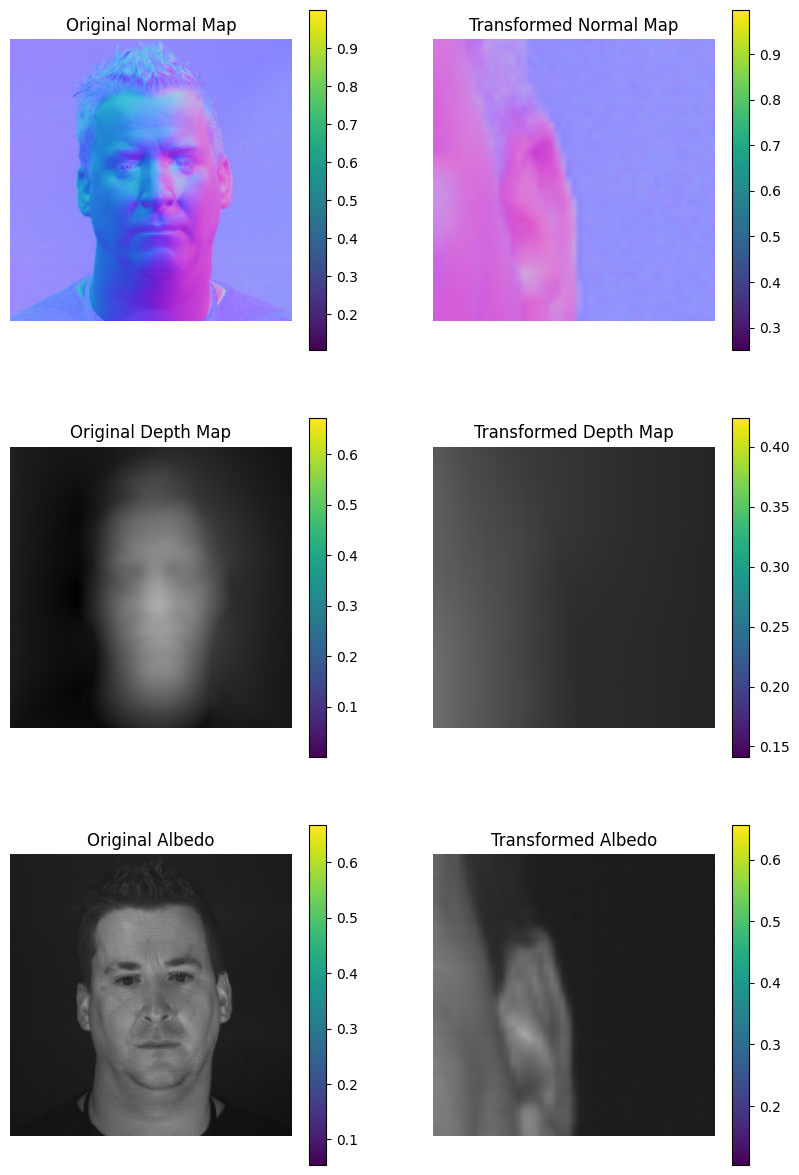

In [75]:
# Vẽ các ảnh sau khi áp dụng transform
plt.figure(figsize=(10, 15))

plt.subplot(3, 2, 1)
plt.title('Original Normal Map')
plt.imshow(normalmap)
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.title('Transformed Normal Map')
plt.imshow(transformed['normalmap'])
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title('Original Depth Map')
plt.imshow(depthmap)
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title('Transformed Depth Map')
plt.imshow(transformed['depthmap'])
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 5)
plt.title('Original Albedo')
plt.imshow(albedo)
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 6)
plt.title('Transformed Albedo')
plt.imshow(transformed['image'])
plt.axis('off')
plt.colorbar()

plt.show()

Gause Noise

In [65]:
class GaussianNoise(A.ImageOnlyTransform):
    
    def __init__(self, mean=0, std=0.1, p =1.0):
        super().__init__(p)
        self.mean = mean
        self.std = std

    def __call__(self, **kwargs):
        row, col, ch = kwargs['image'].shape
        # Tính toán kích thước của vùng ảnh sẽ nhận nhiễu
        min_size = int(row * col * 0.1)
        max_size = int(row * col * 0.25)
        area_size = np.random.randint(min_size, max_size)

        # Tạo ma trận mask để chỉ định vùng của ảnh sẽ nhận nhiễu
        mask = np.zeros((row, col))
        x = np.random.randint(0, col)
        y = np.random.randint(0, row)
        x_end = min(x + int(np.sqrt(area_size)), col)
        y_end = min(y + int(np.sqrt(area_size)), row)
        mask[y:y_end, x:x_end] = 1
        
        # Tạo ma trận nhiễu Gaussian có std ngẫu nhiên
        std = np.random.uniform(0, 0.1)
        gauss = np.random.normal(self.mean, std, (row, col, ch))
        
        # Tiến hành transform trên tất cả các ảnh (chính và bổ sung)
        result = {}

        # Lặp qua tất cả các target (ảnh chính và các ảnh bổ sung)
        for key, image in kwargs.items():
            # Áp dụng nhiễu vào phần của ảnh được chỉ định bởi mask
            noisy_img = image + gauss * mask[:, :, np.newaxis]
            noisy_img = np.clip(noisy_img, 0, 1)
            # Áp dụng biến đổi cho mỗi ảnh với cùng một giá trị random_scale và tọa độ x, y
            result[key] = noisy_img
            
        return result

In [71]:
transform = A.Compose([
    GaussianNoise()
], additional_targets={
    'depthmap': 'image',
    'normalmap': 'image'
})

# Áp dụng transformation
transformed = transform(image=albedo, depthmap=depthmap, normalmap=normalmap)

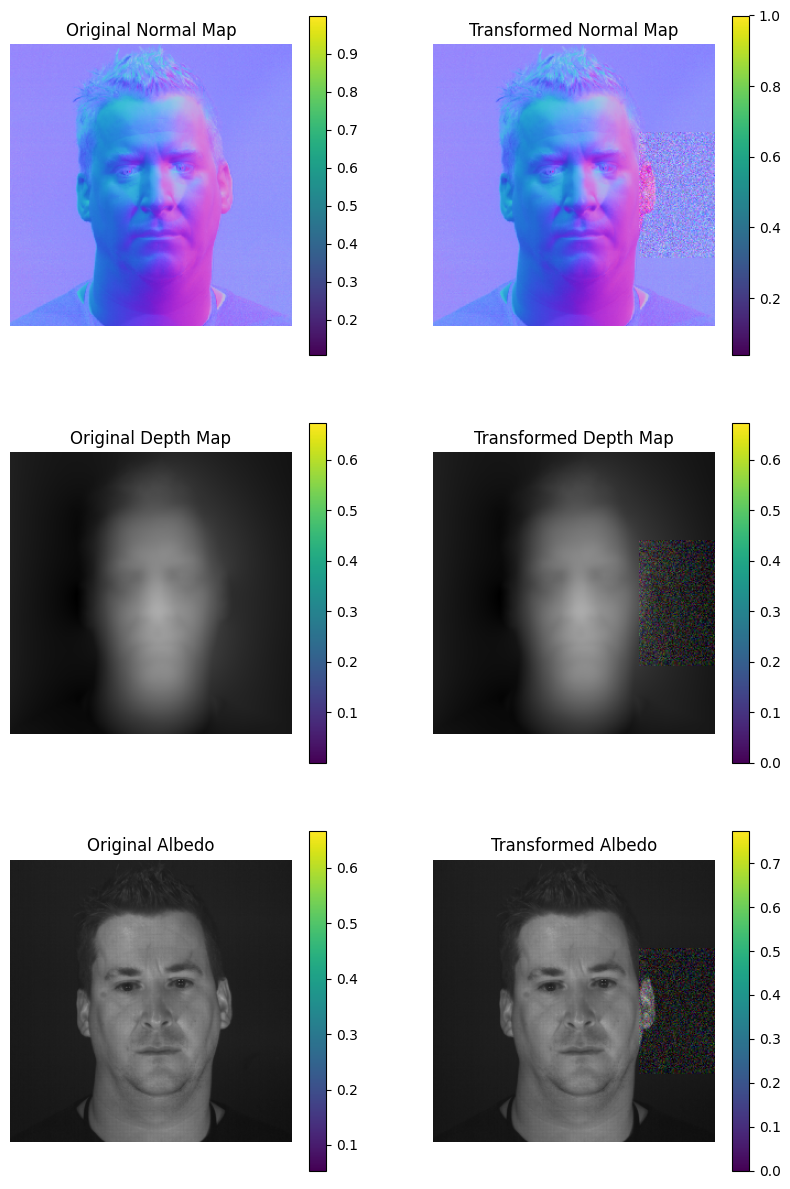

In [72]:
# Vẽ các ảnh sau khi áp dụng transform
plt.figure(figsize=(10, 15))

plt.subplot(3, 2, 1)
plt.title('Original Normal Map')
plt.imshow(normalmap)
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.title('Transformed Normal Map')
plt.imshow(transformed['normalmap'])
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title('Original Depth Map')
plt.imshow(depthmap)
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title('Transformed Depth Map')
plt.imshow(transformed['depthmap'])
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 5)
plt.title('Original Albedo')
plt.imshow(albedo)
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 6)
plt.title('Transformed Albedo')
plt.imshow(transformed['image'])
plt.axis('off')
plt.colorbar()

plt.show()

# Dataset

## Magface concat

In [13]:
class MultiModalExrDataset(Dataset):
    def __init__(self, dataset_dir:str, transform=None, is_train=True):
        split = 'train' if is_train else 'test'
        self.albedo_dir = Path(dataset_dir) / 'Albedo' / split
        self.depth_dir = Path(dataset_dir) / 'Depth_Map' / split
        self.normal_dir = Path(dataset_dir) / 'Normal_Map' / split
        
        self.transform = transform
        self.classes = sorted(os.listdir(self.albedo_dir))
        
        # Collect paths for each modality
        self.data = []
        for class_name in self.classes:
            albedo_class_dir = self.albedo_dir / class_name
            depth_class_dir = self.depth_dir / class_name
            normal_class_dir = self.normal_dir / class_name

            albedo_files = sorted(list(albedo_class_dir.glob("*.exr")))
            depth_files = sorted(list(depth_class_dir.glob("*.exr")))
            normal_files = sorted(list(normal_class_dir.glob("*.exr")))

            assert len(albedo_files) == len(normal_files) == len(depth_files), (
                f"Mismatch in number of files for class {class_name}: Albedo({len(albedo_files)}), "
                f"Normal({len(normal_files)}), Depth({len(depth_files)})"
            )
            class_index = self.classes.index(class_name)
            for albedo_path, normal_path, depth_path in zip(albedo_files, normal_files, depth_files):
                self.data.append((albedo_path, normal_path, depth_path, class_index))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]:
        albedo_path, normal_path, depth_path, class_index = self.data[index]
        
        albedo = self.__load_numpy_image(albedo_path)
        normal = self.__load_numpy_image(normal_path)
        depth = self.__load_numpy_image(depth_path)
        
        if self.transform:
            transformed = self.transform(image=albedo, depthmap=depth, normalmap=normal)
            albedo = transformed['image']
            depth = transformed['depthmap']
            normal = transformed['normalmap']
        
        X = (
            torch.from_numpy(albedo).permute(2,0,1), 
            torch.from_numpy(depth).permute(2,0,1), 
            torch.from_numpy(normal).permute(2,0,1)
        )
        
        return X, class_index
        
    def __load_numpy_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if image is None:
            raise ValueError(f"Failed to load image at {image_path}")
        elif len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        return image

In [14]:
test_dataset = MultiModalExrDataset('./Dataset', transform=transforms, is_train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
dataiter = iter(test_dataloader)
(albedo, depth, normal), class_index = next(dataiter)
print(class_index[0])
print(test_dataset.classes[class_index])

albedo = albedo[0].permute(1,2,0).numpy()
depth = depth[0].permute(1,2,0).numpy()
normal = normal[0].permute(1,2,0).numpy()

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(albedo)
plt.axis('off')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(depth)
plt.axis('off')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(normal)
plt.axis('off')
plt.colorbar()

plt.show()

In [ ]:
albedo_dir = Path('./Dataset') / 'Albedo' / 'train'
print(albedo_dir.exists())
len(sorted(list(albedo_dir.glob("*.exr"))))

## Lâm dataset

In [17]:
from going_modular.dataloader.triplet import TripletDataset

train_dataset = TripletDataset(data_dir='./Dataset/Albedo/train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

In [22]:
dataiter = iter(train_dataloader)
X = next(dataiter)
print(X.shape)

anchors = X[:, 0, :, :, :]
positives = X[:, 1, :, :, :]
negatives = X[:, 2, :, :, :]
print(albedo.shape)

torch.Size([1, 3, 3, 256, 256])
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.048126698..1.002057].


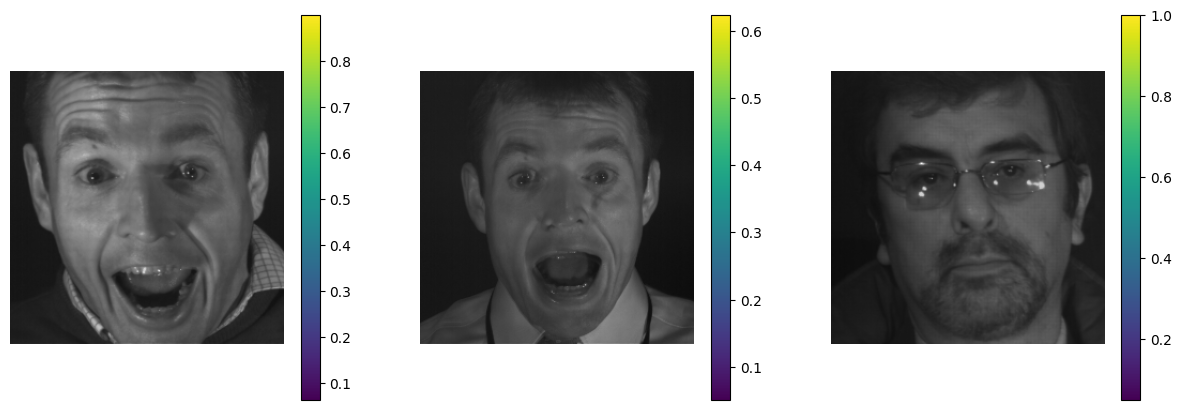

In [23]:
anchor = anchors[0].permute(1,2,0).numpy()
positive = positives[0].permute(1,2,0).numpy()
negative = negatives[0].permute(1,2,0).numpy()

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(anchor)
plt.axis('off')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(positive)
plt.axis('off')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(negative)
plt.axis('off')
plt.colorbar()

plt.show()

# Model

In [2]:

CONFIGURATION = {
    # Thư mục
    'type': 'concat',
    'train_dir': './Dataset/Albedo/train',
    'test_dir': './Dataset/Albedo/test',
    'dataset_dir': './Dataset',
    'albedo_checkpoint': './checkpoint/magface/albedo/models/best_val_cosine_accuracy_270.pth',
    'depthmap_checkpoint': './checkpoint/magface/depthmap/models/best_val_cosine_accuracy_215.pth',
    'normalmap_checkpoint': './checkpoint/magface/normalmap/models/best_val_cosine_accuracy_195.pth',
    
    # Cấu hình train
    'backbone': 'iresnet18',
    'epochs': 2000,
    'num_workers': 4,
    'batch_size': 16,
    'image_size': 224,
    'num_class': len(os.listdir('./Dataset/Albedo/train')),
    'embedding_size': 512,
    
    'learning_rate': 0.2,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'alpha': 0.9,
    
    # Hàm m(ai) giúp thay đổi ai từ 0.25 đến 1.6
    'scale': 64,
    'lambda_g': 20,
    'l_margin': 0.45, 
    'u_margin': 0.8,Em đang sử dụng 
}

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model = MagFaceConcatRecognition(CONFIGURATION)

In [4]:
summary(
    model=model,
    input_size=(32, 3, 3, 224, 224),  # Batch gồm 3 ảnh đầu vào
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
MagFaceConcatRecognition (MagFaceConcatRecognition)     [32, 3, 3, 224, 224] [32, 203]            --                   True
├─MagFaceRecognition (albedo_extractor)                 --                   --                   103,936              True
│    └─iResNet (feature_extractor)                      [32, 3, 224, 224]    [32, 512]            --                   True
│    │    └─Conv2d (conv1)                              [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    │    └─BatchNorm2d (bn1)                           [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    │    └─ReLU (relu)                                 [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    │    └─Sequential (layer1)                         [32, 64, 112, 112]   [32, 64, 56, 56]     147,968              True
│    

# Tensorboard

In [13]:
%load_ext tensorboard
%tensorboard --logdir checkpoint/magface/normalmap/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 11866), started 0:05:13 ago. (Use '!kill 11866' to kill it.)

In [1]:
import pandas as pd
import os

dataset_dir = './Dataset/Albedo'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

for id in os.listdir(train_dir):
    id_path = os.path.join(train_dir, id)
    for filename in os.listdir(id_path):
        // Thêm vào id - session vào file csv

Data đã được lưu vào ./output_train.csv


In [9]:
import pandas as pd
import os

# Đường dẫn dataset
dataset_dir = './Dataset/Albedo'
train_dir = os.path.join(dataset_dir, 'test')

# Tên file CSV đầu ra
output_csv = './test.csv'

# Tạo DataFrame rỗng nếu file chưa tồn tại
if not os.path.exists(output_csv):
    df = pd.DataFrame(columns=['id', 'filename'])
else:
    df = pd.read_csv(output_csv)

# Duyệt qua từng ID và file trong thư mục train
for id in os.listdir(train_dir):
    id_path = os.path.join(train_dir, id)
    if not os.path.isdir(id_path):
        continue
    for filename in os.listdir(id_path):
        file_name_no_ext = os.path.splitext(filename)[0]  # Bỏ phần mở rộng của file
        
        # Thêm thông tin vào DataFrame
        df = pd.concat([df, pd.DataFrame({'id': [id], 'filename': [file_name_no_ext]})], ignore_index=True)

# Ghi lại vào file CSV
df.to_csv(output_csv, index=False)

print(f'Data đã được lưu vào {output_csv}')

Data đã được lưu vào ./test.csv
